In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.datasets import ImageFolder
import random

Net(
  (conv): Sequential(
    (0): NormActConv(
      (norm_act_conv): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): NormActConv(
      (norm_act_conv): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=294912, out_features=1024, bias=True)
    (1): NormActLin(
      (norm_act_conv): Sequential(
        (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1):

In [ ]:
import numpy as np

trans = transforms.Compose(
    [
        transforms.Resize(384),
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transNoAugment = transforms.Compose(
    [
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


data_dir = "Space"
test_size = 64
batch = 8

dataset = ImageFolder(root=data_dir, transform=transNoAugment)

class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices[label].append(idx)

test_indices = []
train_indices = []

for cls, indices in class_to_indices.items():
    random.shuffle(indices)
    test_indices.extend(indices[:test_size])
    train_indices.extend(indices[test_size:])

train_dataset = Subset(ImageFolder(root=data_dir, transform=trans), train_indices)
test_dataset = Subset(dataset, test_indices)

trainLoader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valLoader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(f"Liczba danych w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba danych w zbiorze testowym: {len(test_dataset)}")


FileNotFoundError: [Errno 2] No such file or directory: 'Space'

In [ ]:
from collections import Counter

train_labels = [dataset.samples[idx][1] for idx in train_indices]

class_counts = Counter(train_labels)

print("samples per class:")
for cls, count in class_counts.items():
    print(f"Klasa {cls}: {count}")

total_samples = len(train_dataset)
weights = [total_samples / class_counts[cls] for cls in range(len(dataset.classes))]

class_weights = torch.tensor(weights, dtype=torch.float)

print("\nCrossEntropyLoss weights:")
for cls, weight in enumerate(class_weights):
    print(f"Klasa {cls}: {weight:.4f}")

samples per class:
Klasa 0: 219
Klasa 1: 592
Klasa 2: 352
Klasa 3: 1488
Klasa 4: 2544
Klasa 5: 1128
Klasa 6: 1408
Klasa 7: 3205

CrossEntropyLoss weights:
Klasa 0: 49.9361
Klasa 1: 18.4730
Klasa 2: 31.0682
Klasa 3: 7.3495
Klasa 4: 4.2987
Klasa 5: 9.6950
Klasa 6: 7.7670
Klasa 7: 3.4122


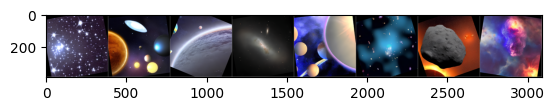

In [ ]:
device = torch.device("cuda")

classes = [
    "Asteroid",
    "Black Hole",
    "Comet",
    "Constellation",
    "Galaxy",
    "Nebula",
    "Planet",
    "Star"
]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(trainLoader))

imshow(torchvision.utils.make_grid(images))

# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [ ]:
from models import Net
net = Net().to(device)

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

eps = 100
load_num = 1

if load_num != 0:
    net.load_state_dict(torch.load(f"models/model_w_{load_num}.pth", weights_only=True))
    optimizer.load_state_dict(torch.load(f"models/opti.pth", weights_only=True))

for epoch in range(eps+1):
    train_loss = 0.0
    val_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    net.train()
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    for i, data in enumerate(valLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

    torch.save(net.state_dict(), f"models/model_w_{epoch+load_num+1}.pth")
    torch.save(optimizer.state_dict(), f"models/opti.pth")

    print(f"ep: {epoch+load_num+1}/{eps}, train_loss: {(train_loss/len(trainLoader)):.4f}, val_loss: {(val_loss/len(valLoader)):.4f}")


TypeError: bad operand type for unary +: 'str'